## 0.预设参数和函数包

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook #用于迭代可视化
from time import time #用于计算时间计算
import torch.optim as optim
from matplotlib import cm
#from mayavi import mlab  # 用于 3D 可视化
from mpl_toolkits.mplot3d import Axes3D # 用于 3D 可视化
from matplotlib.ticker import FormatStrFormatter

# 设置数据类型
DTYPE = torch.float64
# 定义问题参数
L = torch.tensor(2, dtype=DTYPE)  # 板的边长 (m)
E = torch.tensor(1, dtype=DTYPE)  # 杨氏模量 (Pa)<弹性模量>
nu = torch.tensor(0.3, dtype=DTYPE)  # 泊松比
a = torch.tensor(1, dtype=DTYPE) # 裂缝长度 (m)
mu = E / (2 * (1 + nu))# 定义剪切模量G
lmda = E * nu / ((1 + nu) * (1 - 2 * nu)) #拉梅系数\lmda
kappa = 3 - 4 * nu #平面应变

P = torch.tensor(1, dtype=DTYPE)  # 上边界施加的拉应力 (Pa)

# Set boundary 设定边界
xmin = -1.
xmax = 1.
ymin = -1.
ymax = 1.
zmin = -1.
zmax = 1.

torch.set_default_dtype(DTYPE)
num_epochs = int(10000)     #Adam训练步数
num_hidden = 15              #网络深度
num_nodes = 60              #网络广度  
N_l = 1000                  #LBFGS训练步数

#激活函数选择，顺序如下：
#nn.ReLU(),
#Swish(),
#nn.Tanh(),
#nn.Sigmoid(),
#nn.Softplus(), #平滑版本的 ReLU，公式为 f(x) = log(exp(x) + 1)
#nn.Softsign() #输出值在 -1 和 1 之间，公式为 f(x) = x / (1 + |x|)

ACT_function_1 = 0
ACT_function_2 = 1 #Swish()

# 设置数据点
N_bound = 100  #每一边界上的数值点数
N_r = 3000    #内部的数值点数
N_r_J = 200    #在内部选为连接点的点数
N_crack = 200 #裂缝线上的数值点数
N_tip = 100 #裂尖附近的数值点数

## 1.定义精确解

### 模型和解的数学表达

- 1、解的数学形式

![图 1](<截屏2025-05-19 09.31.17.png> "平面问题模型")

- 2、精确解

![图 2](<截屏2025-05-19 09.29.52.png> "平面问题模型")

- 3、我们只设置上下的拉力P=1，裂缝长b=1，板长z=2，因此只存在$K_I$

In [2]:
def calculate_k1(b, z, sigma_y):
    # 计算公式中的每一部分
    term1 = (torch.sqrt(torch.tensor(2.0)) * sigma_y) / ((torch.pi * b)**(3/2))
    term2 = 1 / (1+(z/b)**2)
    # 计算整体表达式
    K1 = term1 * term2
    return K1

def translate_to_cylindrical(x, y, z, tip_x=0.0, tip_y=0.0, tip_z=0.0):
    """
    将三维笛卡尔坐标转换为柱坐标。
    
    参数:
        x, y, z: 原始笛卡尔坐标点
        tip_x, tip_y, tip_z: 坐标系原点位置
        
    返回:
        r: 径向距离（在 xy 平面内）
        theta: 方位角（与 x 轴的夹角）
        z: 高度（沿 z 轴）
    """
    # 计算相对于新原点的坐标
    dx = x - tip_x
    dy = y - tip_y
    dz = z - tip_z
    
    # 计算径向距离 r（在 xy 平面内）
    r = torch.sqrt(dx**2 + dy**2)
    
    # 计算方位角 theta（与 x 轴的夹角）
    # 使用 atan2 以获得正确的角度范围 (-π, π)
    theta = torch.atan2(dy, dx)
    
    # 高度保持不变，只是相对于新原点
    return r, theta, dz


def u_x_ext(x, y, z):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    if not torch.is_tensor(z):
        z = torch.from_numpy(z)
    r, th, _ = translate_to_cylindrical(x, y, z)
    utemp = calculate_k1(a, L, P)/(2*mu)*torch.sqrt(r/(2*torch.pi))* torch.cos(0.5 * th) *(kappa-1+2*(torch.sin(0.5 * th))**2)
    return utemp

def u_y_ext(x, y, z):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    if not torch.is_tensor(z):
        z = torch.from_numpy(z)
    r, th, _ = translate_to_cylindrical(x, y, z)
    utemp = calculate_k1(a, L, P)/(2*mu)*torch.sqrt(r/(2*torch.pi))* torch.sin(0.5 * th) *(kappa+1-2*(torch.cos(0.5 * th))**2)
    return utemp

def u_z_ext(x, y, z):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    if not torch.is_tensor(z):
        z = torch.from_numpy(z)
    return torch.zeros_like(x)

def Sigmaxx_ext(x, y, z):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    if not torch.is_tensor(z):
        z = torch.from_numpy(z)
    r, th, _ = translate_to_cylindrical(x, y, z)
    gtemp = calculate_k1(a, L, P)/ torch.sqrt(2 * torch.pi * r) * torch.cos(0.5 * th) * (1 - torch.sin(0.5 * th) * torch.sin(1.5 * th))
    return gtemp

def Sigmayy_ext(x, y, z):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    if not torch.is_tensor(z):
        z = torch.from_numpy(z)
    r, th, _ = translate_to_cylindrical(x, y, z)
    gtemp = calculate_k1(a, L, P)/ torch.sqrt(2 * torch.pi * r) * torch.cos(0.5 * th) * (1 + torch.sin(0.5 * th) * torch.sin(1.5 * th))
    return gtemp

def Sigmazz_ext(x, y, z):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    if not torch.is_tensor(z):
        z = torch.from_numpy(z)
    gtemp = nu * (Sigmaxx_ext(x, y, z) + Sigmayy_ext(x, y, z))
    return gtemp

def Sigmaxy_ext(x, y, z):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    if not torch.is_tensor(z):
        z = torch.from_numpy(z)
    r, th, _ = translate_to_cylindrical(x, y, z)
    gtemp = calculate_k1(a, L, P) / torch.sqrt(2 * torch.pi * r) * torch.cos(0.5 * th) * torch.sin(0.5 * th) * torch.cos(1.5 * th)
    return gtemp

def Sigmaxz_ext(x, y, z):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    if not torch.is_tensor(z):
        z = torch.from_numpy(z)
    return torch.zeros_like(x)

def Sigmayz_ext(x, y, z):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    if not torch.is_tensor(z):
        z = torch.from_numpy(z)
    return torch.zeros_like(x)

def f_x_ext(x, y, z):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    if not torch.is_tensor(z):
        z = torch.from_numpy(z)
    return torch.zeros_like(x)

def f_y_ext(x, y, z):
    if not torch.is_tensor(x):
        x = torch.from_numpy(x)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y)
    if not torch.is_tensor(z):
        z = torch.from_numpy(z)
    return torch.zeros_like(x)

### 参考解示例

In [3]:
# 设置三维网格
N = 100

# 生成三维网格
xspace = np.linspace(xmin, xmax, N + 1)
yspace = np.linspace(ymin, ymax, N + 1)
zspace = np.linspace(zmin, zmax, N + 1)
X_grid, Y_grid, Z_grid = np.meshgrid(xspace, yspace, zspace, indexing='xy')

# 转换为 PyTorch 张量并调整形状
X_expanded = torch.from_numpy(X_grid).double().reshape(-1)
Y_expanded = torch.from_numpy(Y_grid).double().reshape(-1)
Z_expanded = torch.from_numpy(Z_grid).double().reshape(-1)

# 计算精确解
ux_ext = u_x_ext(X_expanded, Y_expanded, Z_expanded)
uy_ext = u_y_ext(X_expanded, Y_expanded, Z_expanded)
uz_ext = u_z_ext(X_expanded, Y_expanded, Z_expanded)

# 转换为 NumPy 数组并调整维度
Ux_ext = ux_ext.detach().numpy().reshape(N+1, N+1, N+1)
Uy_ext = uy_ext.detach().numpy().reshape(N+1, N+1, N+1)
Uz_ext = uz_ext.detach().numpy().reshape(N+1, N+1, N+1)

# 剪应变计算和可视化
sxx_ext = Sigmaxx_ext(X_expanded, Y_expanded, Z_expanded)
syy_ext = Sigmayy_ext(X_expanded, Y_expanded, Z_expanded)
szz_ext = Sigmazz_ext(X_expanded, Y_expanded, Z_expanded)
sxy_ext = Sigmaxy_ext(X_expanded, Y_expanded, Z_expanded)
sxz_ext = Sigmaxz_ext(X_expanded, Y_expanded, Z_expanded)
syz_ext = Sigmayz_ext(X_expanded, Y_expanded, Z_expanded)

Sxx_ext = sxx_ext.detach().numpy().reshape(N+1, N+1, N+1)
Syy_ext = syy_ext.detach().numpy().reshape(N+1, N+1, N+1)
Sxy_ext = sxy_ext.detach().numpy().reshape(N+1, N+1, N+1)

# 可视化（使用 mayavi 进行 3D 可视化）
# mlab.figure(bgcolor=(1, 1, 1))
# src = mlab.pipeline.scalar_field(Ux_ext)
# mlab.pipeline.iso_surface(src, contours=[0.5 * Ux_ext.max()], opacity=0.5)
# mlab.pipeline.volume(src, vmin=0.2 * Ux_ext.max(), vmax=0.8 * Ux_ext.max())
# mlab.axes(src, color=(0, 0, 0), extent=[xmin, xmax, ymin, ymax, zmin, zmax])
# mlab.show()

In [4]:
def getBoundary_points(xmin,xmax,ymin,ymax,zmin,zmax,DTYPE,N_bound,N_crack):
    # Lower bounds
    lb = torch.tensor([xmin, ymin, zmin], dtype=DTYPE)
    # Upper bounds
    ub = torch.tensor([xmax, ymax, zmax], dtype=DTYPE)

    # Set random seed for reproducible results 随机数种子
    torch.manual_seed(666)

    ###########################################################################
    # Boundary points
    x_up = lhs(1,samples=N_bound)
    x_up = xmin + (xmax-xmin)*x_up
    y_up = np.empty(len(x_up))[:,None]
    y_up.fill(ymax)
    z_up = lhs(1,samples=N_bound)
    z_up = zmin + (zmax-zmin)*z_up

    b_up = np.empty([len(x_up),3])
    b_up[:,0,None] = np.asarray(u_x_ext(x_up, y_up, z_up))
    b_up[:,1,None] = np.asarray(u_y_ext(x_up, y_up, z_up))
    b_up[:,2,None] = np.asarray(u_z_ext(x_up, y_up, z_up))
    x_up_train = np.hstack((x_up, y_up, z_up))###上边界配点

    ux_up_train = b_up[:,0, None] 
    #ux_up_train = np.zeros([len(x_up),1])###上边界x位移
    Syy_up_train = Sigmayy_ext(x_up, y_up, z_up)
    Szz_up_train = Sigmazz_ext(x_up, y_up, z_up)
    #print(Syy_up_train)
    #Syy_up_train = fun_top_yy(x_up, y_up, z_up)###上边界应力条件
    

    x_up_train = torch.Tensor(x_up_train)
    ux_up_train = torch.Tensor(ux_up_train)
    Syy_up_train = torch.Tensor(Syy_up_train)
    Szz_up_train = torch.Tensor(Szz_up_train)

    x_lo = lhs(1,samples=N_bound)
    x_lo = xmin + (xmax-xmin)*x_lo
    y_lo = np.empty(len(x_lo))[:,None]
    y_lo.fill(ymin)
    z_lo = lhs(1,samples=N_bound)
    z_lo = zmin + (zmax-zmin)*z_lo

    b_lo = np.empty([len(x_lo),3])
    b_lo[:,0, None] = np.asarray(u_x_ext(x_lo, y_lo, z_lo))
    b_lo[:,1, None] = np.asarray(u_y_ext(x_lo, y_lo, z_lo))
    b_lo[:,2, None] = np.asarray(u_z_ext(x_lo, y_lo, z_lo))
    x_lo_train = np.hstack((x_lo, y_lo, z_lo))###下边界配点
    ux_lo_train = b_lo[:,0, None]
    uy_lo_train = b_lo[:,1, None]

    #ux_lo_train = np.zeros([len(x_lo),1])###下边界x位移
    #uy_lo_train = np.zeros([len(x_lo),1])###下边界y位移
    Syy_lo_train = Sigmayy_ext(x_lo, y_lo, z_lo)###下边界应力条件
    Szz_lo_train = Sigmazz_ext(x_lo, y_lo, z_lo)###下边界应力条件
    #Syy_lo_train = fun_bot_yy(x_lo, y_lo, z_lo)###下边界应力条件

    x_lo_train = torch.Tensor(x_lo_train)
    ux_lo_train = torch.Tensor(ux_lo_train)
    uy_lo_train = torch.Tensor(uy_lo_train)
    Syy_lo_train = torch.Tensor(Syy_lo_train)
    Szz_lo_train = torch.Tensor(Szz_lo_train)

    y_ri = lhs(1,samples=N_bound)
    y_ri = ymin + (ymax-ymin)*y_ri
    x_ri = np.empty(len(y_ri))[:,None]
    x_ri.fill(xmax)
    z_ri = lhs(1,samples=N_bound)
    z_ri = zmin + (zmax-zmin)*z_ri
    b_ri = np.empty([len(x_ri),3])
    b_ri[:,0, None] = np.asarray(u_x_ext(x_ri, y_ri, z_ri))
    b_ri[:,1, None] = np.asarray(u_y_ext(x_ri, y_ri, z_ri))
    b_ri[:,2, None] = np.asarray(u_z_ext(x_ri, y_ri, z_ri))
    x_ri_train = np.hstack((x_ri, y_ri, z_ri)) ###右边界配点
    # ux_ri_train = b_ri[:,0, None]
    uy_ri_train = b_ri[:,1, None]###右边界y位移
    uz_ri_train = b_ri[:,2, None]###右边界z位移
    #uy_ri_train = np.zeros([len(x_ri),1])###右边界y位移（固定支撑）
    Sxx_ri_train = Sigmaxx_ext(x_ri, y_ri, z_ri)###右边界sxx应力
    Szz_ri_train = Sigmazz_ext(x_ri, y_ri, z_ri)###右边界sxx应力
    #Sxx_ri_train = np.zeros([len(x_ri),1])###右边界sxx应力（固定支撑）

    x_ri_train = torch.Tensor(x_ri_train)
    uy_ri_train = torch.Tensor(uy_ri_train)
    uz_ri_train = torch.Tensor(uz_ri_train)
    Sxx_ri_train = torch.Tensor(Sxx_ri_train)
    Szz_ri_train = torch.Tensor(Szz_ri_train)

    y_le = lhs(1,samples=N_bound)
    y_le = ymin + (ymax-ymin)*y_le
    x_le = np.empty(len(y_le))[:,None]
    x_le.fill(xmin)
    z_le = lhs(1,samples=N_bound)
    z_le = zmin + (zmax-zmin)*z_le

    b_le = np.empty([len(x_le),3])
    b_le[:,0, None] = np.asarray(u_x_ext(x_le, y_le, z_le))
    b_le[:,1, None] = np.asarray(u_y_ext(x_le, y_le, z_le))
    b_le[:,2, None] = np.asarray(u_z_ext(x_le, y_le, z_le))
    x_le_train = np.hstack((x_le, y_le, z_le))###左边界配点
    # ux_le_train = b_le[:,0, None]
    uy_le_train = b_le[:,1, None]###左边界y位移
    #uy_le_train = np.zeros([len(x_le),1])###左边界y位移（固定支撑）
    Sxx_le_train = Sigmaxx_ext(x_le, y_le, z_le)###左边界sxx应力
    Szz_le_train = Sigmazz_ext(x_le, y_le, z_le)###左边界sxx应力
    #Sxx_le_train = np.zeros([len(x_le),1])###左边界sxx应力（固定支撑）

    x_le_train = torch.Tensor(x_le_train)
    uy_le_train = torch.Tensor(uy_le_train)
    Sxx_le_train = torch.Tensor(Sxx_le_train)
    Szz_le_train = torch.Tensor(Szz_le_train)

    # crack bc points 
    x_crack = lhs(1,samples=N_crack)
    x_crack = xmin + ((xmax-xmin)*0.5)*x_crack
    y_crack = np.empty(len(x_crack))[:,None]
    y_crack.fill((xmax+xmin)*0.5)
    z_crack = lhs(1,samples=N_crack)
    z_crack = zmin + (zmax-zmin)*z_crack

    crack = np.empty([len(x_crack),3])
    crack[:,0,None] = np.asarray(u_x_ext(x_crack, y_crack, z_crack))
    crack[:,1,None] = np.asarray(u_y_ext(x_crack, y_crack, z_crack))
    crack[:,2,None] = np.asarray(u_z_ext(x_crack, y_crack, z_crack))
    crack_train = np.hstack((x_crack, y_crack, z_crack))###裂缝配点

    Sxx_crack_train = np.zeros([len(x_crack),1])###裂缝界应力条件
    Syy_crack_train = np.zeros([len(x_crack),1])###裂缝界应力条件
    Szz_crack_train = np.zeros([len(x_crack),1])###裂缝界应力条件
    Sxy_crack_train = np.zeros([len(x_crack),1])###裂缝界应力条件
    Sxz_crack_train = np.zeros([len(x_crack),1])###裂缝界应力条件
    Syz_crack_train = np.zeros([len(x_crack),1])###裂缝界应力条件

    crack_train = torch.Tensor(crack_train)
    Sxx_crack_train = torch.Tensor(Sxx_crack_train)
    Syy_crack_train = torch.Tensor(Syy_crack_train)
    Szz_crack_train = torch.Tensor(Szz_crack_train)
    Sxy_crack_train = torch.Tensor(Sxy_crack_train)
    Sxz_crack_train = torch.Tensor(Sxz_crack_train)
    Syz_crack_train = torch.Tensor(Syz_crack_train)

    X_b_train = torch.cat((x_up_train, x_lo_train, x_ri_train, x_le_train, crack_train), dim=0)

    X_train_list = [x_up_train, x_lo_train, x_ri_train, x_le_train, crack_train]

    ux_b_train = torch.cat((ux_up_train, ux_lo_train), dim=0)
    uy_b_train = torch.cat((uy_lo_train, uy_ri_train, uy_le_train), dim=0)
    uz_b_train = uz_ri_train

    Sxx_b_train = torch.cat((Sxx_ri_train, Sxx_le_train), dim=0)
    Syy_b_train = torch.cat((Syy_up_train, Syy_lo_train), dim=0)
    Szz_b_train = torch.cat((Szz_up_train, Szz_lo_train), dim=0)
    Sxx_crack_train = Sxx_crack_train
    Syy_crack_train = Syy_crack_train
    Szz_crack_train = Szz_crack_train
    Sxy_crack_train = Sxy_crack_train
    Sxz_crack_train = Sxz_crack_train
    Syz_crack_train = Syz_crack_train

    return X_b_train, X_train_list, ux_b_train, uy_b_train, uz_b_train, Sxx_b_train, Syy_b_train, Szz_b_train,\
        Sxx_crack_train, Syy_crack_train, Szz_crack_train, Sxy_crack_train, Sxz_crack_train, Syz_crack_train

In [5]:
def getCollocation_points_m(xmin,xmax,ymin,ymax,zmin,zmax,N_r,N_r_J,N_tip):
    #########################################################################
    # collocation points for PINNs
    # 使用拉丁超立方抽样（Latin Hypercube Sampling, LHS）生成的一组用于PINNs的配置点（collocation points）。
    # 使用 lhs 函数生成一个包含 N_r-N_r_J-N_tip 行和2列的数组，每一行代表一个二维空间中的点
    grid_pt = lhs(3,N_r-N_r_J-N_tip)
    grid_pt[:,0] = xmin + (xmax-xmin)*grid_pt[:,0] # 将第一列的每个点从 [0, 1] 区间线性映射到 [xmin, xmax] 区间
    grid_pt[:,1] = ymin + (ymax-ymin)*grid_pt[:,1]
    grid_pt[:,2] = zmin + (zmax-zmin)*grid_pt[:,2]

    # collocation Junction points for PINNs
    # 使用 lhs 函数生成一个包含 N_r_J 行和2列的数组，每一行代表一个二维空间中的点
    grid_jpt = lhs(3,N_r_J)
    # 将第一列的每个点从 [0, 1] 区间线性映射到连接线((xmax+xmin)*0.5, xmax]区间
    grid_jpt[:,0] = (xmax+xmin)*0.5+(xmax-xmin)*0.01 + (xmax-(xmax+xmin)*0.5)*grid_jpt[:,0]
    grid_jpt[:,1] = 0 + 0*grid_jpt[:,1] # 将第一列的每个点从 [0, 1] 区间线性映射到连接线y==0
    grid_jpt[:,2] = zmin + (zmax-zmin)*grid_jpt[:,2]

    
# collocation Tip points for PINNs
    # 使用 lhs 函数生成一个包含 N_tip/2 行和2列的数组，每一行代表一个二维空间中的点
    N_tip = int(N_tip)
    N_tip = N_tip//2
    grid_tptl = lhs(3,N_tip)
    # 将第一列的每个点从 [0, 1] 区间线性映射到连接线[-0.25, 0.25]区间
    grid_tptl[:,0] = -0.25 + (0.25-(-0.25))*grid_tptl[:,0]
    grid_tptl[:,1] = -0.25 + (0-(-0.25))*0.999*grid_tptl[:,1] # 将第一列的每个点从 [0, 1] 区间线性映射到连接线[-0.25, 0)
    grid_tptl[:,2] = zmin + (zmax-zmin)*grid_tptl[:,2]

    grid_tptu = lhs(3,N_tip)
    # 将第一列的每个点从 [0, 1] 区间线性映射到连接线[-0.25, 0.25]区间
    grid_tptu[:,0] = -0.25 + (0.25-(-0.25))*grid_tptu[:,0]
    grid_tptu[:,1] = 0.001 + (0.25-(0.001))*grid_tptu[:,1] # 将第一列的每个点从 [0, 1] 区间线性映射到连接线(0, 0.25]
    grid_tptu[:,2] = zmin + (zmax-zmin)*grid_tptu[:,2]

    #添加裂尖点
    #grid_tip = lhs(2,1)*0

    # 分别提取出 x 和 y 坐标的值
    xf = np.concatenate((grid_pt[:,0], grid_jpt[:,0],grid_tptl[:,0],grid_tptu[:,0]))
    yf = np.concatenate((grid_pt[:,1], grid_jpt[:,1],grid_tptl[:,1],grid_tptu[:,1]))
    zf = np.concatenate((grid_pt[:,2], grid_jpt[:,2],grid_tptl[:,2],grid_tptu[:,2]))

    X_col_train = np.hstack((xf[:,None],yf[:,None],zf[:,None])) # 使用 NumPy 的 hstack 函数将 x, y和 z 坐标水平堆叠起来，形成一个新的二维数组
    X_col_train = torch.Tensor(X_col_train)

    return X_col_train



### 生产训练数据（边界和内部配置点）

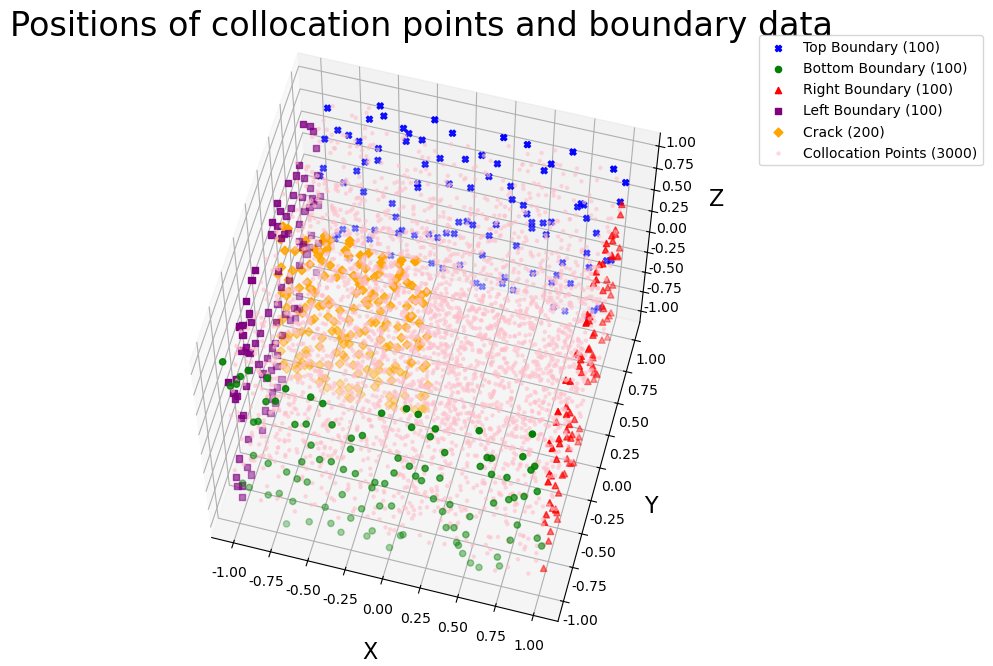

In [6]:
# Lower bounds
lb = torch.tensor([xmin, ymin, zmin], dtype=DTYPE)
# Upper bounds
ub = torch.tensor([xmax, ymax, zmax], dtype=DTYPE)

X_b_train, X_train_list, ux_b_train, uy_b_train, uz_b_train, Sxx_b_train, Syy_b_train, Szz_b_train, \
    Sxx_crack_train, Syy_crack_train, Szz_crack_train, Sxy_crack_train, Sxz_crack_train, Syz_crack_train = getBoundary_points(xmin,xmax,ymin,ymax,zmin,zmax,DTYPE,N_bound,N_crack)
X_col_train = getCollocation_points_m(xmin,xmax,ymin,ymax,zmin,zmax,N_r,N_r_J,N_tip)


#绘制采样点
[x_up_train, x_lo_train, x_ri_train, x_le_train, crack_train] = X_train_list
# 创建一个三维图形
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

# 绘制边界点
boundary_data = [
    (x_up_train, 'blue', 'X', 'Top Boundary'),
    (x_lo_train, 'green', 'o', 'Bottom Boundary'),
    (x_ri_train, 'red', '^', 'Right Boundary'),
    (x_le_train, 'purple', 's', 'Left Boundary'),
    (crack_train, 'orange', 'D', 'Crack')
]

for boundary_train, color, marker, label in boundary_data:
    ax.scatter(boundary_train[:, 0], boundary_train[:, 1], boundary_train[:, 2], c=color, marker=marker, label=f"{label} ({len(boundary_train)})")

# 绘制配置点
ax.scatter(X_col_train[:, 0], X_col_train[:, 1], X_col_train[:, 2], c='pink', marker='.', alpha=0.5, label=f"Collocation Points ({len(X_col_train)})")

# 设置坐标轴标签
ax.set_xlabel('X', labelpad=15, fontsize=16)
ax.set_ylabel('Y', labelpad=15, fontsize=16)
ax.set_zlabel('Z', labelpad=15, fontsize=16)
ax.set_aspect('equal')

# 设置标题
ax.set_title('Positions of collocation points and boundary data',pad=5, fontsize=24)

# 显示图例
ax.legend(loc=(1.05, 0.8))
# 设置坐标轴刻度格式为两位小数
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# 设置视角
ax.view_init(elev=60, azim=-75)

# 显示图形
plt.tight_layout()
plt.show()

## 2、网络设置

In [7]:
# 定义 Swish 激活函数
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# 定义神经网络模型
class MNN(nn.Module):
    def __init__(self, layers, labels=1):
        super().__init__()
        # Initialise neural network as a list using nn.ModuleList
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # 对每个层的权重进行了Xavier正态初始化，同时将偏置设置为零
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
        
        # 定义激活函数，这里我们使用ReLU和Swish作为示例
        self.activations = [
            nn.ReLU(),
            Swish(),
            nn.Tanh(),
            nn.Sigmoid(),
            nn.Softplus(), #平滑版本的 ReLU，公式为 f(x) = log(exp(x) + 1)
            nn.Softsign() #输出值在 -1 和 1 之间，公式为 f(x) = x / (1 + |x|)
        ]

    def forward(self, x, labels):
        if not torch.is_tensor(x):          
            x = torch.from_numpy(x)
        for i in range(len(self.linears)-1):  
            x = self.linears[i](x)
            x = self.activations[labels](x)
        x = self.linears[-1](x)
        output_Ux = x[:,0][:,None]
        output_Uy = x[:,1][:,None]
        output_Uz = x[:,2][:,None]
        output_Sxx = x[:,3][:,None]
        output_Syy = x[:,4][:,None]
        output_Szz = x[:,5][:,None]
        output_Sxy = x[:,6][:,None]
        output_Sxz = x[:,7][:,None]
        output_Syz = x[:,8][:,None]
        return output_Ux, output_Uy, output_Uz, output_Sxx, output_Syy, output_Szz, output_Sxy, output_Sxz, output_Syz
    
# Create the model
layers = [3] + num_hidden * [num_nodes] + [9]
modelMNN = MNN(layers)
#print(model) #打印模型结构

In [8]:
def split_tensors_by_condition(x, y, z, condition_func_x=None, condition_func_y=None, condition_func_z=None):
    """
    根据条件函数将x、y、z张量分成两组。

    参数:
    x -- 第一个张量
    y -- 第二个张量
    z -- 第三个张量
    condition_func_x -- 针对x的条件函数，接受x作为参数，返回一个布尔张量
    condition_func_y -- 针对y的条件函数，接受y作为参数，返回一个布尔张量
    condition_func_z -- 针对z的条件函数，接受z作为参数，返回一个布尔张量

    返回:
    x_true, y_true, z_true, x_false, y_false, z_false -- 满足和不满足条件的坐标
    labels_t -- 满足条件的标签
    labels_f -- 不满足条件的标签
    """
    # 应用条件函数获取布尔索引
    if condition_func_x is not None:
        condition_x = condition_func_x(x)
    else:
        condition_x = torch.ones_like(x).bool()
    if condition_func_y is not None:
        condition_y = condition_func_y(y)
    else:
        condition_y = torch.ones_like(y).bool()
    if condition_func_z is not None:
        condition_z = condition_func_z(z)
    else:
        condition_z = torch.ones_like(z).bool()
    
    if condition_func_x is None and condition_func_y is None and condition_func_z is None:
        raise ValueError("至少需要提供一个条件函数")
    else:
        condition = condition_x & condition_y & condition_z

    # 使用布尔索引筛选张量
    x_true = x[condition].unsqueeze(1)  # 将x_t转换为形状[m, 1]
    y_true = y[condition].unsqueeze(1)
    z_true = z[condition].unsqueeze(1)
    x_false = x[~condition].unsqueeze(1)
    y_false = y[~condition].unsqueeze(1)
    z_false = z[~condition].unsqueeze(1)

    # 这里假设ACT_function_1和ACT_function_2是定义好的标签函数
    labels_t = ACT_function_1
    labels_f = ACT_function_2

    return x_true, y_true, z_true, x_false, y_false, z_false, labels_t, labels_f

def split_target_by_condition(x, y, z, target, condition_func_x=None, condition_func_y=None, condition_func_z=None):
    """
    根据条件函数将目标target分成两组。

    参数:
    x -- 第一个张量
    y -- 第二个张量
    z -- 第三个张量
    target -- 目标张量
    condition_func_x -- 针对x的条件函数，接受x作为参数，返回一个布尔张量
    condition_func_y -- 针对y的条件函数，接受y作为参数，返回一个布尔张量
    condition_func_z -- 针对z的条件函数，接受z作为参数，返回一个布尔张量

    返回:
    target_true -- 满足条件的目标
    target_false -- 不满足条件的目标
    """
    # 应用条件函数获取布尔索引
    if condition_func_x is not None:
        condition_x = condition_func_x(x)
    else:
        condition_x = torch.ones_like(x).bool()
    if condition_func_y is not None:
        condition_y = condition_func_y(y)
    else:
        condition_y = torch.ones_like(y).bool()
    if condition_func_z is not None:
        condition_z = condition_func_z(z)
    else:
        condition_z = torch.ones_like(z).bool()
    
    if condition_func_x is None and condition_func_y is None and condition_func_z is None:
        raise ValueError("至少需要提供一个条件函数")
    else:
        condition = condition_x & condition_y & condition_z

    # 使用布尔索引筛选张量
    target_true = target[condition].unsqueeze(1)  # 将 x_t 转换为形状 [m, 1]
    target_false = target[~condition].unsqueeze(1)

    return target_true, target_false

## 3、损失函数

#### PED损失

In [9]:
def fun_r_x(x, y, z, dsxxdx, dsxydy, dsxzdz):
    return dsxxdx + dsxydy + dsxzdz

def fun_r_y(x, y, z, dsxydx, dsyydy, dsyzdz):
    return dsxydx + dsyydy + dsyzdz

def fun_r_z(x, y, z, dsxzdx, dsyzdy, dszzdz):
    return dsxzdx + dsyzdy + dszzdz

def fun_r_const_x(x, y, z, duxdx, duydy, duzdz, Sxx):
    return (lmda + 2 * mu) * duxdx + lmda * duydy + lmda * duzdz - Sxx

def fun_r_const_y(x, y, z, duxdx, duydy, duzdz, Syy):
    return (lmda + 2 * mu) * duydy + lmda * duxdx + lmda * duzdz - Syy

def fun_r_const_z(x, y, z, duxdx, duydy, duzdz, Szz):
    return (lmda + 2 * mu) * duzdz + lmda * duxdx + lmda * duydy - Szz

def fun_r_const_xy(x, y, z, duxdy, duydx, Sxy):
    return 2 * mu * 0.5 * (duxdy + duydx) - Sxy

def fun_r_const_xz(x, y, z, duzdx, duxdz, Sxz):
    return 2 * mu * 0.5 * (duxdz + duzdx) - Sxz

def fun_r_const_yz(x, y, z, duzdy, duydz, Syz):
    return 2 * mu * 0.5 * (duzdy + duydz) - Syz

#ux_b_train, uy_b_train, Sxx_b_train, Syy_b_train, Sxx_crack_train, Syy_crack_train, Sxy_crack_train
#的顺序需要依据x，y重配置的顺序改变，否则训练会出错
def fun_b_r_ux(ux_up, ux_lo, ux_b_train):
    return torch.cat((ux_up, ux_lo), dim=0) - ux_b_train

def fun_b_r_uy(uy_lo,uy_ri, uy_le, uy_b_train):
    return torch.cat((uy_lo,uy_ri, uy_le), dim=0) - uy_b_train

def fun_b_r_uz(uz_ri, uz_b_train):
    return uz_ri - uz_b_train

def fun_b_r_Sxx(Sxx_ri, Sxx_le, Sxx_b_train):
    return torch.cat((Sxx_ri, Sxx_le), dim=0) - Sxx_b_train

def fun_b_r_Syy(Syy_up,Syy_lo, Syy_b_train):
    return torch.cat((Syy_up,Syy_lo), dim=0) - Syy_b_train

def fun_b_r_Szz(Szz_up, Szz_lo, Szz_b_train):
    return torch.cat((Szz_up, Szz_lo), dim=0) - Szz_b_train


def fun_crack_r_Sxx(Sxx_crack, Sxx_crack_train):
    return Sxx_crack - Sxx_crack_train

def fun_crack_r_Syy(Syy_crack, Syy_crack_train):
    return Syy_crack - Syy_crack_train

def fun_crack_r_Szz(Szz_crack, Szz_crack_train):
    return Szz_crack - Szz_crack_train

def fun_crack_r_Sxy(Sxy_crack, Sxy_crack_train):
    return Sxy_crack - Sxy_crack_train

def fun_crack_r_Sxz(Sxz_crack, Sxz_crack_train):
    return Sxz_crack - Sxz_crack_train

def fun_crack_r_Syz(Syz_crack, Syz_crack_train):
    return Syz_crack - Syz_crack_train

In [10]:

#内部点处的数值LOSS和PED_LOSS

def compute_grads(var_t, var_f, x_t, y_t, z_t, x_f, y_f, z_f):
    grads_t = torch.autograd.grad(var_t, [x_t, y_t, z_t], torch.ones_like(var_t), create_graph=True)
    grads_f = torch.autograd.grad(var_f, [x_f, y_f, z_f], torch.ones_like(var_f), create_graph=True)
    grads_x_t, grads_y_t, grads_z_t = grads_t[0], grads_t[1], grads_t[2]
    grads_x_f, grads_y_f, grads_z_f = grads_f[0], grads_f[1], grads_f[2]
    return (torch.cat((grads_x_t, grads_x_f), dim=0),
            torch.cat((grads_y_t, grads_y_f), dim=0),
            torch.cat((grads_z_t, grads_z_f), dim=0))

def get_r(model, X_col_train):
    # Split x, y, z to compute partial derivatives
    x = X_col_train[:, 0].clone().requires_grad_(True)[:, None]
    y = X_col_train[:, 1].clone().requires_grad_(True)[:, None]
    z = X_col_train[:, 2].clone().requires_grad_(True)[:, None]
    x_t, y_t, z_t, x_f, y_f, z_f, labels_t, labels_f = split_tensors_by_condition(x, y, z, None, lambda y:y < 0, None)
    #print(torch.hstack([x, y]).shape, torch.hstack([x_t, y_t]).shape)
    # Determine residual

    # Determine residual
    Ux_t, Uy_t, Uz_t, Sxx_t, Syy_t, Szz_t, Sxy_t, Sxz_t, Syz_t = model(torch.hstack([x_t, y_t, z_t]), labels_t)
    Ux_f, Uy_f, Uz_f, Sxx_f, Syy_f, Szz_f, Sxy_f, Sxz_f, Syz_f = model(torch.hstack([x_f, y_f, z_f]), labels_f)
    x = torch.cat((x_t, x_f), dim=0).clone().requires_grad_(True)[:, None]
    y = torch.cat((y_t, y_f), dim=0).clone().requires_grad_(True)[:, None]
    z = torch.cat((z_t, z_f), dim=0).clone().requires_grad_(True)[:, None]

    duxdx, duxdy, duxdz = compute_grads(Ux_t, Ux_f, x_t, y_t, z_t, x_f, y_f, z_f)
    duydx, duydy, duydz = compute_grads(Uy_t, Uy_f, x_t, y_t, z_t, x_f, y_f, z_f)
    duzdx, duzdy, duzdz = compute_grads(Uz_t, Uz_f, x_t, y_t, z_t, x_f, y_f, z_f)

    dsxxdx, _, _ = compute_grads(Sxx_t, Sxx_f, x_t, y_t, z_t, x_f, y_f, z_f)
    _, dsyydy, _ = compute_grads(Syy_t, Syy_f, x_t, y_t, z_t, x_f, y_f, z_f)
    _, _, dszzdz = compute_grads(Szz_t, Szz_f, x_t, y_t, z_t, x_f, y_f, z_f)
    dsxydx, dsxydy, _ = compute_grads(Sxy_t, Sxy_f, x_t, y_t, z_t, x_f, y_f, z_f)
    dsxzdx, _, dsxzdz = compute_grads(Sxz_t, Sxz_f, x_t, y_t, z_t, x_f, y_f, z_f)
    _, dsyzdy, dsyzdz = compute_grads(Syz_t, Syz_f, x_t, y_t, z_t, x_f, y_f, z_f)

    sxx = torch.cat((Sxx_t, Sxx_f), dim=0)
    syy = torch.cat((Syy_t, Syy_f), dim=0)
    szz = torch.cat((Szz_t, Szz_f), dim=0)
    sxy = torch.cat((Sxy_t, Sxy_f), dim=0)
    sxz = torch.cat((Sxz_t, Sxz_f), dim=0)
    syz = torch.cat((Syz_t, Syz_f), dim=0)

    return fun_r_x(x, y, z, dsxxdx, dsxydy, dsxzdz), fun_r_y(x, y, z, dsxydx, dsyydy, dsyzdz), fun_r_z(x, y, z, dsxzdx, dsyzdy, dszzdz),\
        fun_r_const_x(x, y, z, duxdx, duydy, duzdz, sxx), fun_r_const_y(x, y, z, duxdx, duydy, duzdz, syy), fun_r_const_z(x, y, z, duxdx, duydy, duzdz, szz),\
            fun_r_const_xy(x, y, z, duxdy, duydx, sxy), fun_r_const_xz(x, y, z, duzdx, duxdz, sxz), fun_r_const_yz(x, y, z, duzdy, duydz, syz)

#### 连接处的损失

In [11]:
def get_ir(model, X_col_train):
    # Split x, y, z to compute partial derivatives
    x = X_col_train[:, 0].clone().requires_grad_(True)[:, None]
    y = X_col_train[:, 1].clone().requires_grad_(True)[:, None]
    z = X_col_train[:, 2].clone().requires_grad_(True)[:, None]
    
    # 筛选出x > 0且y == 0+-0.02且的元素
    x_t, y_t, z_t, _, _, _, labels_t, labels_f = split_tensors_by_condition(x, y, z, lambda x: x > 0, lambda y: (y > -0.02) & (y < 0.02), None)
    
    # 检查x_t、y_t或z_t是否为空
    if x_t.numel() == 0 or y_t.numel() == 0 or z_t.numel() == 0:
        return 0.0
    
    # Determine residual
    Ux_0, Uy_0, Uz_0, Sxx_0, Syy_0, Szz_0, Sxy_0, Sxz_0, Syz_0 = model(torch.hstack([x_t, y_t, z_t]), labels_t)
    Ux_1, Uy_1, Uz_1, Sxx_1, Syy_1, Szz_1, Sxy_1, Sxz_1, Syz_1 = model(torch.hstack([x_t, y_t, z_t]), labels_f)

    ux = Ux_0 - Ux_1
    uy = Uy_0 - Uy_1
    uz = Uz_0 - Uz_1

    # 硬连续条件
    grads_Ux_0 = torch.autograd.grad(Ux_0, [x_t, y_t, z_t], torch.ones_like(Ux_0), create_graph=True)
    grads_Ux_1 = torch.autograd.grad(Ux_1, [x_t, y_t, z_t], torch.ones_like(Ux_1), create_graph=True)
    Uxdx_0, Uxdy_0, Uxdz_0 = grads_Ux_0[0], grads_Ux_0[1], grads_Ux_0[2]
    Uxdx_1, Uxdy_1, Uxdz_1 = grads_Ux_1[0], grads_Ux_1[1], grads_Ux_1[2]
    Uxdx = Uxdx_0 - Uxdx_1
    Uxdy = Uxdy_0 - Uxdy_1
    Uxdz = Uxdz_0 - Uxdz_1

    grads_Uy_0 = torch.autograd.grad(Uy_0, [x_t, y_t, z_t], torch.ones_like(Uy_0), create_graph=True)
    grads_Uy_1 = torch.autograd.grad(Uy_1, [x_t, y_t, z_t], torch.ones_like(Uy_1), create_graph=True)
    Uydx_0, Uydy_0, Uydzt_0 = grads_Uy_0[0], grads_Uy_0[1], grads_Uy_0[2]
    Uydx_1, Uydy_1, Uydzt_1 = grads_Uy_1[0], grads_Uy_1[1], grads_Uy_1[2]
    Uydx = Uydx_0 - Uydx_1
    Uydy = Uydy_0 - Uydy_1
    Uydzt = Uydzt_0 - Uydzt_1

    grads_Uz_0 = torch.autograd.grad(Uz_0, [x_t, y_t, z_t], torch.ones_like(Uz_0), create_graph=True)
    grads_Uz_1 = torch.autograd.grad(Uz_1, [x_t, y_t, z_t], torch.ones_like(Uz_1), create_graph=True)
    Uzdx_0, Uzdy_0, Uzdz_0 = grads_Uz_0[0], grads_Uz_0[1], grads_Uz_0[2]
    Uzdx_1, Uzdy_1, Uzdz_1 = grads_Uz_1[0], grads_Uz_1[1], grads_Uz_1[2]
    Uzdx = Uzdx_0 - Uzdx_1
    Uzdy = Uzdy_0 - Uzdy_1
    Uzdz = Uzdz_0 - Uzdz_1

    Sxx = Sxx_0 - Sxx_1
    Syy = Syy_0 - Syy_1
    Szz = Szz_0 - Szz_1
    Sxy = Sxy_0 - Sxy_1
    Sxz = Sxz_0 - Sxz_1
    Syz = Syz_0 - Syz_1

    return torch.mean(torch.abs(ux)**2) + torch.mean(torch.abs(uy)**2) + torch.mean(torch.abs(uz)**2) \
        + torch.mean(torch.abs(Uxdx)**2) + torch.mean(torch.abs(Uxdy)**2) + torch.mean(torch.abs(Uxdz)**2) \
        + torch.mean(torch.abs(Uydx)**2) + torch.mean(torch.abs(Uydy)**2) + torch.mean(torch.abs(Uydzt)**2) \
        + torch.mean(torch.abs(Uzdx)**2) + torch.mean(torch.abs(Uzdy)**2) + torch.mean(torch.abs(Uzdz)**2) \
        + torch.mean(torch.abs(Sxx)**2) + torch.mean(torch.abs(Syy)**2) + torch.mean(torch.abs(Szz)**2) \
        + torch.mean(torch.abs(Sxy)**2) + torch.mean(torch.abs(Sxz)**2) + torch.mean(torch.abs(Syz)**2)

#### 边界处的损失

In [12]:
def get_b_r_uS(model, X_train_list, ux_b_train, uy_b_train, uz_b_train,
               Sxx_b_train, Syy_b_train, Szz_b_train,
               Sxx_crack_train, Syy_crack_train, Szz_crack_train, Sxy_crack_train, Sxz_crack_train, Syz_crack_train):
    x_up_train, x_lo_train, x_ri_train, x_le_train, crack_train = X_train_list[0], \
                    X_train_list[1], X_train_list[2], X_train_list[3], X_train_list[4]
    # Split x, y, z to compute partial derivatives
    x_up, y_up, z_up = x_up_train[:, 0][:, None], x_up_train[:, 1][:, None], x_up_train[:, 2][:, None]
    x_lo, y_lo, z_lo = x_lo_train[:, 0][:, None], x_lo_train[:, 1][:, None], x_lo_train[:, 2][:, None]
    x_ri, y_ri, z_ri = x_ri_train[:, 0][:, None], x_ri_train[:, 1][:, None], x_ri_train[:, 2][:, None]
    x_le, y_le, z_le = x_le_train[:, 0][:, None], x_le_train[:, 1][:, None], x_le_train[:, 2][:, None]
    x_crack, y_crack, z_crack = crack_train[:, 0][:, None], crack_train[:, 1][:, None], crack_train[:, 2][:, None]

    # 上边界、下边界和裂缝自然不用分类
    x_ri_t, y_ri_t, z_ri_t, x_ri_f, y_ri_f, z_ri_f, labels_ri_t, labels_ri_f = split_tensors_by_condition(
        x_ri, y_ri, z_ri, None, lambda y: y < 0, None)
    x_le_t, y_le_t, z_le_t, x_le_f, y_le_f, z_le_f, labels_le_t, labels_le_f = split_tensors_by_condition(
        x_le, y_le, z_le, None, lambda y: y < 0, None)

    # Determine residual
    Ux_up, Uy_up, Uz_up, Sxx_up, Syy_up, Szz_up, Sxy_up, Sxz_up, Syz_up = model(torch.hstack((x_up, y_up, z_up)), labels_ri_f)
    Ux_lo, Uy_lo, Uz_lo, Sxx_lo, Syy_lo, Szz_lo, Sxy_lo, Sxz_lo, Syz_lo = model(torch.hstack((x_lo, y_lo, z_lo)), labels_ri_t)
    Ux_crack, Uy_crack, Uz_crack, Sxx_crack, Syy_crack, Szz_crack, Sxy_crack, Sxz_crack, Syz_crack = model(torch.hstack((x_crack, y_crack, z_crack)), labels_ri_f)

    Ux_ri_t, Uy_ri_t, Uz_ri_t, Sxx_ri_t, _, _, _, _, _ = model(torch.hstack((x_ri_t, y_ri_t, z_ri_t)), labels_ri_t)
    Ux_ri_f, Uy_ri_f, Uz_ri_f, Sxx_ri_f, _, _, _, _, _ = model(torch.hstack((x_ri_f, y_ri_f, z_ri_f)), labels_ri_f)

    Ux_ri = torch.cat((Ux_ri_t, Ux_ri_f), dim=0).clone().requires_grad_(True)
    Uy_ri = torch.cat((Uy_ri_t, Uy_ri_f), dim=0).clone().requires_grad_(True)
    Uz_ri = torch.cat((Uz_ri_t, Uz_ri_f), dim=0).clone().requires_grad_(True)
    Sxx_ri = torch.cat((Sxx_ri_t, Sxx_ri_f), dim=0).clone().requires_grad_(True)

    Ux_le_t, Uy_le_t, Uz_le_t, Sxx_le_t, _, _, _, _, _ = model(torch.hstack((x_le_t, y_le_t, z_le_t)), labels_le_t)
    Ux_le_f, Uy_le_f, Uz_le_f, Sxx_le_f, _, _, _, _, _ = model(torch.hstack((x_le_f, y_le_f, z_le_f)), labels_le_f)

    Ux_le = torch.cat((Ux_le_t, Ux_le_f), dim=0).clone().requires_grad_(True)
    Uy_le = torch.cat((Uy_le_t, Uy_le_f), dim=0).clone().requires_grad_(True)
    Uz_le = torch.cat((Uz_le_t, Uz_le_f), dim=0).clone().requires_grad_(True)
    Sxx_le = torch.cat((Sxx_le_t, Sxx_le_f), dim=0).clone().requires_grad_(True)

    # 修正 uy_b_train, uz_b_train
    uy_lo_train_extracted = uy_b_train[:N_bound].clone()
    uy_ri_train_extracted = uy_b_train[N_bound:2*N_bound].clone()
    uy_le_train_extracted = uy_b_train[2*N_bound:3*N_bound].clone()
    uy_ri_train_extracted_t, uy_ri_train_extracted_f = split_target_by_condition(x_ri, y_ri, z_ri, uy_ri_train_extracted, None, lambda y: y < 0, None)
    uy_ri_train_extracted = torch.cat((uy_ri_train_extracted_t, uy_ri_train_extracted_f), dim=0)
    uy_le_train_extracted_t, uy_le_train_extracted_f = split_target_by_condition(x_le, y_le, z_le, uy_le_train_extracted, None, lambda y: y < 0, None)
    uy_le_train_extracted = torch.cat((uy_le_train_extracted_t, uy_le_train_extracted_f), dim=0)
    uy_b_train = torch.cat((uy_lo_train_extracted, uy_ri_train_extracted, uy_le_train_extracted), dim=0)

    
    uz_ri_train_extracted = uz_b_train[:N_bound].clone()
    uz_ri_train_extracted_t, uz_ri_train_extracted_f = split_target_by_condition(x_ri, y_ri, z_ri, uz_ri_train_extracted, None, lambda y: y < 0, None)
    uz_ri_train_extracted = torch.cat((uz_ri_train_extracted_t, uz_ri_train_extracted_f), dim=0)
    uz_b_train = uz_ri_train_extracted


    # 修正 Sxx_b_train
    Sxx_ri_train_extracted = Sxx_b_train[:N_bound].clone()
    Sxx_le_train_extracted = Sxx_b_train[N_bound:2*N_bound].clone()
    Sxx_ri_train_extracted_t, Sxx_ri_train_extracted_f = split_target_by_condition(x_ri, y_ri, z_ri, Sxx_ri_train_extracted, None, lambda y: y < 0, None)
    Sxx_ri_train_extracted = torch.cat((Sxx_ri_train_extracted_t, Sxx_ri_train_extracted_f), dim=0)
    Sxx_le_train_extracted_t, Sxx_le_train_extracted_f = split_target_by_condition(x_le, y_le, z_le, Sxx_le_train_extracted, None, lambda y: y < 0, None)
    Sxx_le_train_extracted = torch.cat((Sxx_le_train_extracted_t, Sxx_le_train_extracted_f), dim=0)
    Sxx_b_train = torch.cat((Sxx_ri_train_extracted, Sxx_le_train_extracted), dim=0)

    # 对应的，不用修正 ux_b_train, Syy_b_train, Szz_b_train, Sxy_b_train, Sxz_b_train, Syz_b_train

    ux_up, _, _ = Ux_up, Uy_up, Uz_up
    ux_lo, uy_lo, uz_lo = Ux_lo, Uy_lo, Uz_lo
    _, uy_ri, uz_ri = Ux_ri, Uy_ri, Uz_ri
    _, uy_le, uz_le = Ux_le, Uy_le, Uz_le

    return (fun_b_r_ux(ux_up, ux_lo, ux_b_train), 
            fun_b_r_uy(uy_lo, uy_ri, uy_le, uy_b_train),
            fun_b_r_uz(uz_ri, uz_b_train),
            fun_b_r_Sxx(Sxx_ri, Sxx_le, Sxx_b_train), 
            fun_b_r_Syy(Syy_up, Syy_lo, Syy_b_train),
            fun_b_r_Szz(Szz_up, Szz_lo, Szz_b_train),
            fun_crack_r_Sxx(Sxx_crack, Sxx_crack_train),
            fun_crack_r_Syy(Syy_crack, Syy_crack_train),
            fun_crack_r_Szz(Szz_crack, Szz_crack_train),
            fun_crack_r_Sxy(Sxy_crack, Sxy_crack_train),
            fun_crack_r_Sxz(Sxz_crack, Sxz_crack_train),
            fun_crack_r_Syz(Syz_crack, Syz_crack_train))

### 损失函数汇总

In [13]:
def compute_loss_addCrack(model, X_col_train, X_train_list, ux_b_train, uy_b_train, uz_b_train,
                          Sxx_b_train, Syy_b_train, Szz_b_train,
                          Sxx_crack_train, Syy_crack_train, Szz_crack_train, Sxy_crack_train, Sxz_crack_train, Syz_crack_train):

    # Compute phi^r use absolute error
    rx, ry, rz, rx_const, ry_const, rz_const, rxy_const, rxz_const, ryz_const = get_r(model, X_col_train)
    phi_r = torch.mean(torch.abs(rx)**2) + torch.mean(torch.abs(ry)**2) + torch.mean(torch.abs(rz)**2)
    phi_r_const = torch.mean(torch.abs(rx_const)**2) + torch.mean(torch.abs(ry_const)**2) + torch.mean(torch.abs(rz_const)**2) + \
                  torch.mean(torch.abs(rxy_const)**2) + torch.mean(torch.abs(rxz_const)**2) + torch.mean(torch.abs(ryz_const)**2)
    phi_ir = get_ir(model, X_col_train)

    # Compute phi^b
    r_ux, r_uy, r_uz, r_Sxx, r_Syy, r_Szz, rc_Sxx, rc_Syy, rc_Szz, rc_Sxy, rc_Sxz, rc_Syz = get_b_r_uS(
        model, X_train_list, ux_b_train, uy_b_train, uz_b_train,
        Sxx_b_train, Syy_b_train, Szz_b_train,
        Sxx_crack_train, Syy_crack_train, Szz_crack_train, Sxy_crack_train, Sxz_crack_train, Syz_crack_train
    )
    phi_r_u = torch.mean(torch.abs(r_ux)**2) + torch.mean(torch.abs(r_uy)**2) + torch.mean(torch.abs(r_uz)**2)
    phi_r_S = torch.mean(torch.abs(r_Sxx)**2) + torch.mean(torch.abs(r_Syy)**2) + torch.mean(torch.abs(r_Szz)**2) + \
              torch.mean(torch.abs(rc_Sxx)**2) + torch.mean(torch.abs(rc_Syy)**2) + torch.mean(torch.abs(rc_Szz)**2) + \
              torch.mean(torch.abs(rc_Sxy)**2) + torch.mean(torch.abs(rc_Sxz)**2) + torch.mean(torch.abs(rc_Syz)**2)
    #loss = phi_r**(1/3) + phi_r_const**(1/3) + phi_r_u**(1/3) + phi_r_S**(1/3) + phi_ir**(1/3)
    loss = phi_r + phi_r_const + phi_r_u + phi_r_S + phi_ir
    return loss, phi_r, phi_r_const, phi_r_u, phi_r_S, phi_ir


def get_grad_addCrack(model, X_col_train, X_train_list, ux_b_train, uy_b_train, uz_b_train,
                      Sxx_b_train, Syy_b_train, Szz_b_train,
                      Sxx_crack_train, Syy_crack_train, Szz_crack_train, Sxy_crack_train, Sxz_crack_train, Syz_crack_train):
    # Set requires_grad=True for trainable parameters
    for param in model.parameters():
        param.requires_grad = True

    # Forward pass and compute loss
    loss, phi_r, phi_r_const, phi_r_u, phi_r_S, phi_ir = compute_loss_addCrack(
        model, X_col_train, X_train_list, ux_b_train, uy_b_train, uz_b_train,
        Sxx_b_train, Syy_b_train, Szz_b_train,
        Sxx_crack_train, Syy_crack_train, Szz_crack_train, Sxy_crack_train, Sxz_crack_train, Syz_crack_train
    )

    # Backward pass
    loss.backward()

    # Get gradients
    g = [param.grad.clone() for param in model.parameters()]

    return loss, g, phi_r, phi_r_const, phi_r_u, phi_r_S, phi_ir

## 4、训练模型

In [14]:
from torch.optim.lr_scheduler import MultiStepLR
from tqdm import tqdm

# Choose the optimizer
lr = 1e-2  # 学习率，更新梯度的时候使用

optimizer = optim.Adam(modelMNN.parameters(), lr=lr)
scheduler = MultiStepLR(optimizer=optimizer, milestones=[num_epochs // 20, num_epochs // 10], gamma=0.1)

# Number of training epochs
N = num_epochs
hist = []
hist_loss = []
hist_phi_r = []
hist_phi_r_const = []
hist_phi_r_u = []
hist_phi_r_S = []
hist_phi_ir = []

In [15]:

# Define a training step
def train_step():
    # Zero the gradients
    optimizer.zero_grad()

    # Compute current loss
    loss, grad_theta, phi_r, phi_r_const, phi_r_u, phi_r_S, phi_ir = get_grad_addCrack(
        modelMNN, X_col_train, X_train_list, ux_b_train, uy_b_train, uz_b_train,
        Sxx_b_train, Syy_b_train, Szz_b_train,
        Sxx_crack_train, Syy_crack_train, Szz_crack_train, Sxy_crack_train, Sxz_crack_train, Syz_crack_train
    )

    # Perform gradient descent step
    for i, param in enumerate(modelMNN.parameters()):
        param.grad = grad_theta[i]

    optimizer.step()

    return loss.item(), phi_r.item(), phi_r_const.item(), phi_r_u.item(), phi_r_S.item(), phi_ir.item()

# Start timer
t0 = time()

for i in tqdm(range(N + 1)):
    loss, phi_r, phi_r_const, phi_r_u, phi_r_S, phi_ir = train_step()

    if i == 0:
        loss0 = loss
    hist.append(loss / loss0)
    hist_loss.append(loss)

    # Append the values to their respective lists
    hist_phi_r.append(phi_r)
    hist_phi_r_const.append(phi_r_const)
    hist_phi_r_u.append(phi_r_u)
    hist_phi_r_S.append(phi_r_S)
    hist_phi_ir.append(phi_ir)

    if hist[-1] <= 1e-12:
        print('Loss threshold reached. Stopping training.')
        break

    # Output current loss after every 1000 iterates
    if i % 1000 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i, loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time() - t0))

  0%|          | 1/10001 [00:00<49:01,  3.40it/s]

It 00000: loss = 4.00101789e-03


 10%|█         | 1001/10001 [04:25<39:34,  3.79it/s]

It 01000: loss = 2.49909338e-04


 20%|██        | 2001/10001 [08:51<36:03,  3.70it/s]

It 02000: loss = 2.75867864e-04


 30%|███       | 3001/10001 [13:21<31:01,  3.76it/s]

It 03000: loss = 9.77389778e+01


 40%|████      | 4001/10001 [17:46<26:13,  3.81it/s]

It 04000: loss = 3.49740324e+01


 50%|█████     | 5001/10001 [22:11<22:05,  3.77it/s]  

It 05000: loss = 1.73268198e+01


 60%|██████    | 6001/10001 [27:00<17:47,  3.75it/s]  

It 06000: loss = 9.86468279e+00


 70%|███████   | 7001/10001 [31:35<13:10,  3.79it/s]

It 07000: loss = 5.98882348e+00


 80%|████████  | 8001/10001 [36:14<09:00,  3.70it/s]  

It 08000: loss = 3.20816548e+00


 90%|█████████ | 9001/10001 [40:49<03:48,  4.37it/s]  

It 09000: loss = 2.12132117e+00


100%|██████████| 10001/10001 [44:45<00:00,  3.72it/s]

It 10000: loss = 1.33375411e+00

Computation time: 2685.0382499694824 seconds


In [16]:
# 选择不同的优化方法LBFGS
opt_LBFGS = torch.optim.LBFGS(modelMNN.parameters(), lr=lr, max_iter=20)
# 不同方法的loss
loss_LBFGS = []

# Define a training step
def train_LBFGS_step():
    opt_LBFGS.zero_grad()

    # Define the closure function
    def closure():
        opt_LBFGS.zero_grad()
        loss, grad_theta, phi_r, phi_r_const, phi_r_u, phi_r_S, phi_ir = get_grad_addCrack(
        modelMNN, X_col_train, X_train_list, ux_b_train, uy_b_train, uz_b_train,
        Sxx_b_train, Syy_b_train, Szz_b_train,
        Sxx_crack_train, Syy_crack_train, Szz_crack_train, Sxy_crack_train, Sxz_crack_train, Syz_crack_train
        )
        for i, param in enumerate(modelMNN.parameters()):
            param.grad = grad_theta[i]
        return loss

    # Perform the optimization step
    loss = opt_LBFGS.step(closure)

    # Extract the loss and other values from the closure
    loss, grad_theta, phi_r, phi_r_const, phi_r_u, phi_r_S, phi_ir = get_grad_addCrack(
        modelMNN, X_col_train, X_train_list, ux_b_train, uy_b_train, uz_b_train,
        Sxx_b_train, Syy_b_train, Szz_b_train,
        Sxx_crack_train, Syy_crack_train, Szz_crack_train, Sxy_crack_train, Sxz_crack_train, Syz_crack_train
    )

    return loss.item(), phi_r.item(), phi_r_const.item(), phi_r_u.item(), phi_r_S.item(), phi_ir.item()

# Start timer
t0 = time()

for i in tqdm(range(N_l+1)):
    loss, phi_r, phi_r_const, phi_r_u, phi_r_S, phi_ir = train_LBFGS_step()

    #将状态加载到优化器
    #optimizer.load_state_dict(optimizer_state)

    loss_LBFGS.append(loss / loss0)

    if loss_LBFGS[-1] <= 1e-10:
        print('Loss threshold reached. Stopping training.')
        break

    # Output current loss after 50 iterates
    if i % 1000 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i, loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time() - t0))

  0%|          | 1/1001 [00:04<1:15:03,  4.50s/it]

It 00000: loss = 1.52740949e+00


100%|██████████| 1001/1001 [34:02<00:00,  2.04s/it] 

It 01000: loss = 2.64680564e-03

Computation time: 2042.6274268627167 seconds


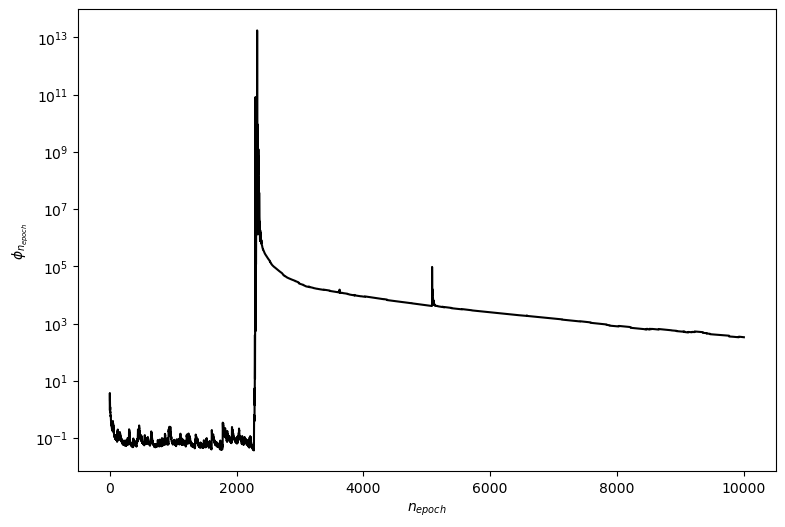

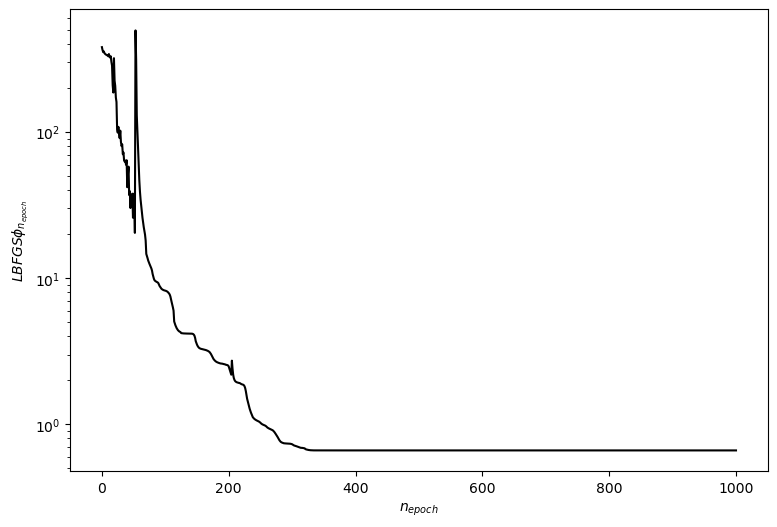

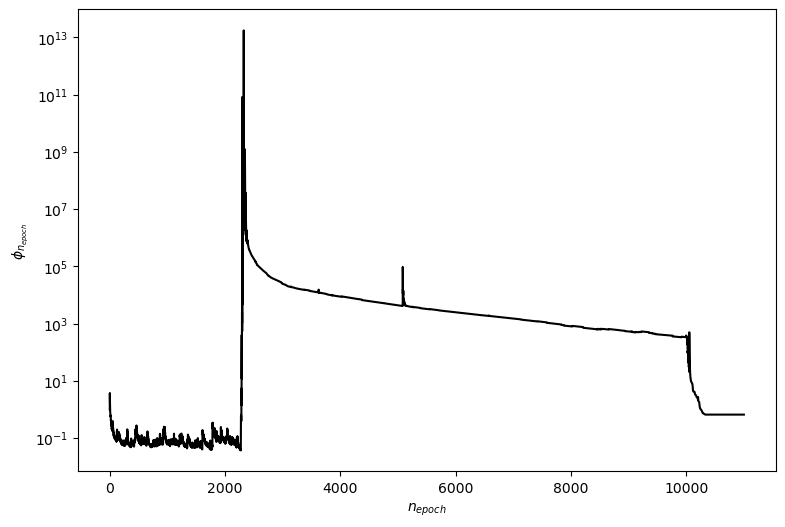

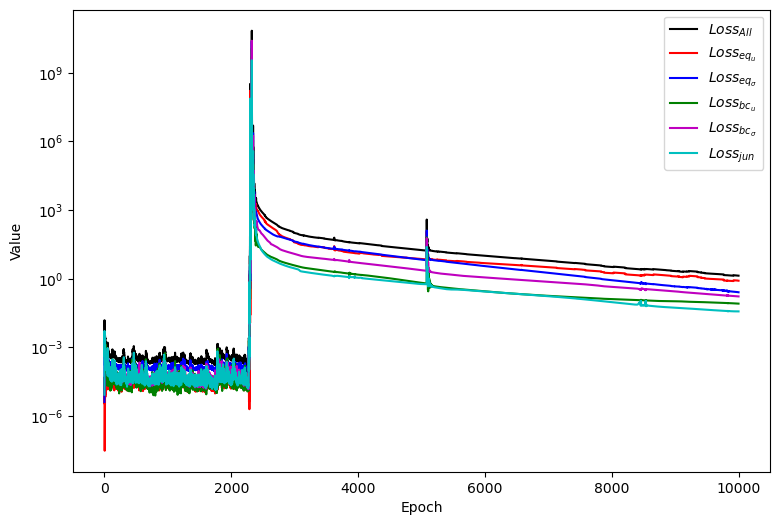

In [17]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel(r'$\phi_{n_{epoch}}$')
plt.show()

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(loss_LBFGS)), loss_LBFGS,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel(r'$LBFGS\phi_{n_{epoch}}$')
plt.show()


hist_Adma_LB = np.concatenate((hist, loss_LBFGS))
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist_Adma_LB)), hist_Adma_LB,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel(r'$\phi_{n_{epoch}}$')
plt.show()

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
# 绘制损失值的半对数图
ax.semilogy(range(len(hist)), hist_loss, 'k-', label='$Loss_{All}$')
# 绘制 phi_r, phi_r_const, phi_r_u, phi_r_S, phi_ir 的半对数图
ax.semilogy(range(len(hist_phi_r)), hist_phi_r, 'r-', label='$Loss_{eq_u}$')
ax.semilogy(range(len(hist_phi_r_const)), hist_phi_r_const, 'b-', label=r'$Loss_{eq_\sigma}$')
ax.semilogy(range(len(hist_phi_r_u)), hist_phi_r_u, 'g-', label='$Loss_{bc_u}$')
ax.semilogy(range(len(hist_phi_r_S)), hist_phi_r_S, 'm-', label=r'$Loss_{bc_\sigma}$')
ax.semilogy(range(len(hist_phi_ir)), hist_phi_ir, 'c-', label='$Loss_{jun}$')
#ax.semilogy(range(len(hist_phi_crack)), hist_phi_crack, 'y-', label='$Loss_{crack}$')
ax.set_xlabel('Epoch')
ax.set_ylabel('Value')
ax.legend()
plt.show()


### 保存整个模型


In [18]:
torch.save(modelMNN, 'model_ipinn.pth')

import pickle

data = {
    'hist': hist,
    'hist_loss': hist_loss,
    'hist_phi_r': hist_phi_r,
    'hist_phi_r_const': hist_phi_r_const,
    'hist_phi_r_u': hist_phi_r_u,
    'hist_phi_r': hist_phi_r,
    'hist_phi_r_S': hist_phi_r_S,
    'hist_phi_ir': hist_phi_ir
}

with open('training_hist_ipinn.pkl', 'wb') as f:
    pickle.dump(data, f)

### 结果及分析

In [19]:
import pickle
modelMNN = torch.load('model_ipinn.pth', weights_only=False)

with open('training_hist_ipinn.pkl', 'rb') as f:
    loaded_data = pickle.load(f)
hist = loaded_data['hist']
hist_loss = loaded_data['hist_loss']
hist_phi_r = loaded_data['hist_phi_r']
hist_phi_r_const = loaded_data['hist_phi_r_const']
hist_phi_r_u = loaded_data['hist_phi_r_u']
hist_phi_r_S = loaded_data['hist_phi_r_S']
hist_phi_ir = loaded_data['hist_phi_ir']

In [20]:
# # Set up meshgrid
N = 100
# xspace = np.linspace(xmin, xmax, N + 1)
# yspace = np.linspace(ymin, ymax, N + 1)
# zspace = np.linspace(zmin, zmax, N + 1)
# X, Y, Z = np.meshgrid(xspace, yspace, zspace, indexing='ij')

# # 转换为 PyTorch 张量并调整形状
# X_expanded = torch.from_numpy(X).float().reshape(-1)
# Y_expanded = torch.from_numpy(Y).float().reshape(-1)
# Z_expanded = torch.from_numpy(Z).float().reshape(-1)

x_t, y_t, z_t, x_f, y_f, z_f, labels_t, labels_f = split_tensors_by_condition(X_expanded, Y_expanded, Y_expanded, None, lambda y:y < 0, None)

# Determine predictions of u(t, x)
Ux_pred_t, Uy_pred_t, Uz_pred_t, Sxx_pred_t, Syy_pred_t, Szz_pred_t, Sxy_pred_t, Sxz_pred_t, Syz_pred_t = modelMNN(torch.hstack([x_t, y_t, z_t]), labels_t)
Ux_pred_f, Uy_pred_f, Uz_pred_f, Sxx_pred_f, Syy_pred_f, Szz_pred_f, Sxy_pred_f, Sxz_pred_f, Syz_pred_f = modelMNN(torch.hstack([x_f, y_f, z_f]), labels_f)

ux_pred = torch.cat((Ux_pred_t, Ux_pred_f), dim=0)
uy_pred = torch.cat((Uy_pred_t, Uy_pred_f), dim=0)
Sxx_pred = torch.cat((Sxx_pred_t, Sxx_pred_f), dim=0)
Syy_pred = torch.cat((Syy_pred_t, Syy_pred_f), dim=0)
Sxy_pred = torch.cat((Sxy_pred_t, Sxy_pred_f), dim=0)


# Reshape upred
Ux = ux_pred.detach().numpy().reshape(N+1, N+1, N+1)
Uy = uy_pred.detach().numpy().reshape(N+1, N+1, N+1)
Uhat = np.sqrt(Ux*Ux+Uy*Uy)

Sxx = Sxx_pred.detach().numpy().reshape(N+1, N+1, N+1)
Syy = Syy_pred.detach().numpy().reshape(N+1, N+1, N+1)
Sxy = Sxy_pred.detach().numpy().reshape(N+1, N+1, N+1)


# calculate exact solutions
ux_ext = u_x_ext(X_expanded,Y_expanded,Z_expanded)
uy_ext = u_y_ext(X_expanded,Y_expanded,Z_expanded)

# Reshape upred
Ux_ext = ux_ext.detach().numpy().reshape(N+1, N+1, N+1)
Uy_ext = uy_ext.detach().numpy().reshape(N+1, N+1, N+1)
Uhat_ext = np.sqrt(Ux_ext*Ux_ext+Uy_ext*Uy_ext)

sxx_ext = Sigmaxx_ext(X_expanded,Y_expanded,Z_expanded)
syy_ext = Sigmayy_ext(X_expanded,Y_expanded,Z_expanded)
sxy_ext = Sigmaxy_ext(X_expanded,Y_expanded,Z_expanded)

Sxx_ext = sxx_ext.detach().numpy().reshape(N+1, N+1, N+1)
Syy_ext = syy_ext.detach().numpy().reshape(N+1, N+1, N+1)
Sxy_ext = sxy_ext.detach().numpy().reshape(N+1, N+1, N+1)


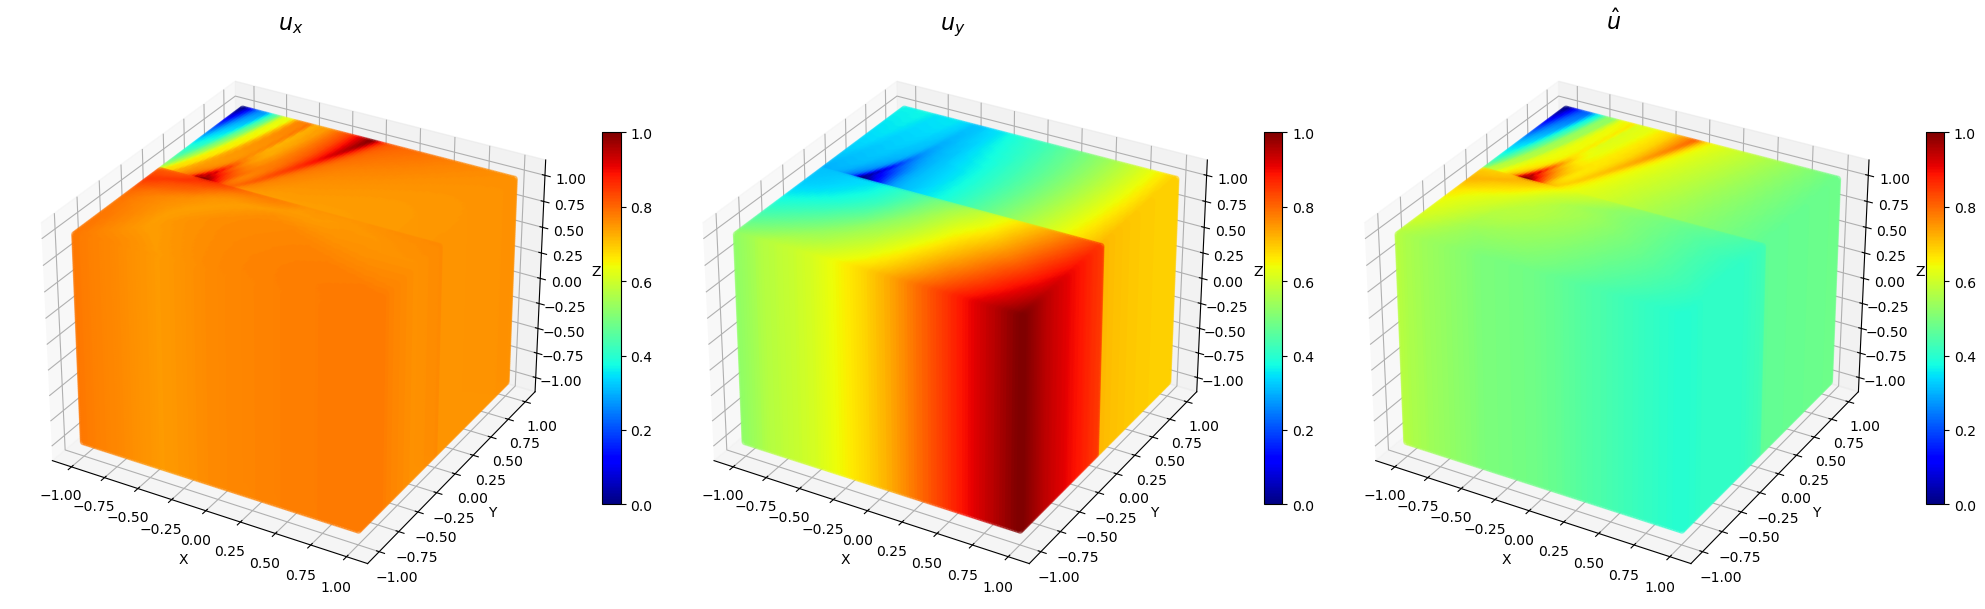

In [21]:
# 创建一个 3×1 的子图布局
fig, axs = plt.subplots(1, 3, figsize=(20, 6.5), subplot_kw={'projection': '3d'})

# 绘制 Ux 图像
axs[0].scatter(X_grid, Y_grid, Z_grid, c=Ux.ravel(), cmap='jet', alpha=0.5)
axs[0].set_title(r'${u_x}$', fontsize = 16)
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_zlabel('Z')
fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=axs[0], fraction=0.046, shrink=0.6, aspect=20)

# 绘制 Uy 图像
axs[1].scatter(X_grid, Y_grid, Z_grid, c=Uy.ravel(), cmap='jet', alpha=0.5)
axs[1].set_title(r'${u_y}$', fontsize = 16)
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
axs[1].set_zlabel('Z')
fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=axs[1], fraction=0.046, shrink=0.6, aspect=20)

# 绘制 Uhat 图像
axs[2].scatter(X_grid, Y_grid, Z_grid, c=Uhat.ravel(), cmap='jet', alpha=0.5)
axs[2].set_title(r'${\hat{u}}$', fontsize = 16)
axs[2].set_xlabel('X')
axs[2].set_ylabel('Y')
axs[2].set_zlabel('Z')
fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=axs[2], fraction=0.046, shrink=0.6, aspect=20)

# 调整子图间距
plt.tight_layout()

# 显示图像
plt.show()

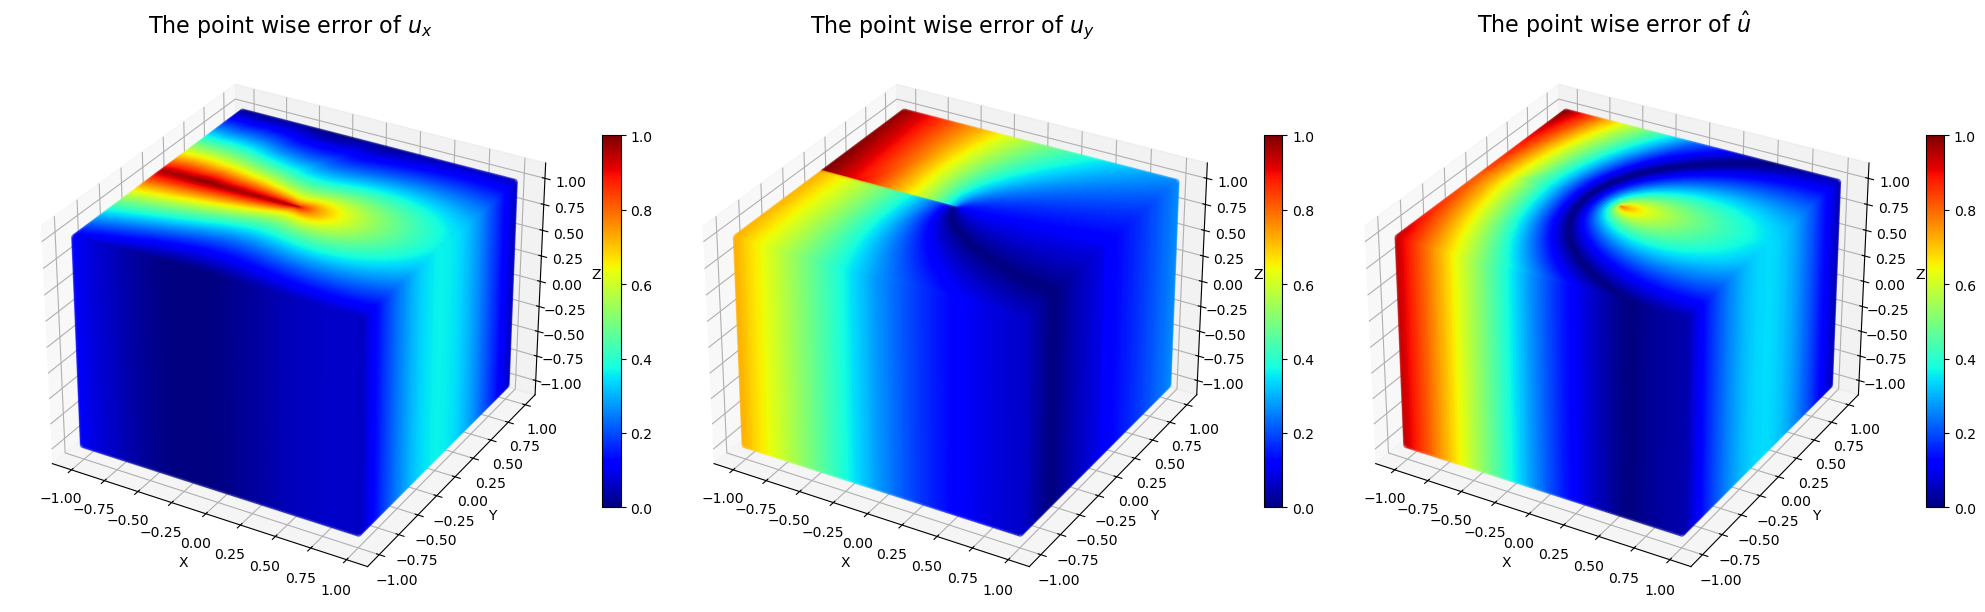

In [22]:
# 创建一个 3×1 的子图布局
fig, axs = plt.subplots(1, 3, figsize=(20, 6.5), subplot_kw={'projection': '3d'})

e_Ux = abs(Ux-Ux_ext)
e_Uy = abs(Uy-Uy_ext)
e_Uhat = abs(Uhat-Uhat_ext)

# 绘制 e_Ux 图像
axs[0].scatter(X_grid, Y_grid, Z_grid, c=e_Ux.ravel(), cmap='jet', alpha=0.5)
axs[0].set_title(r'The point wise error of $u_x$', fontsize = 16)
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_zlabel('Z')
fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=axs[0], fraction=0.046, shrink=0.6, aspect=20)

# 绘制 e_Uy 图像
axs[1].scatter(X_grid, Y_grid, Z_grid, c=e_Uy.ravel(), cmap='jet', alpha=0.5)
axs[1].set_title(r'The point wise error of $u_y$', fontsize = 16)
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
axs[1].set_zlabel('Z')
fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=axs[1], fraction=0.046, shrink=0.6, aspect=20)

# 绘制 e_Uhat 图像
axs[2].scatter(X_grid, Y_grid, Z_grid, c=e_Uhat.ravel(), cmap='jet', alpha=0.5)
axs[2].set_title(r'The point wise error of $\hat{u}$', fontsize = 16)
axs[2].set_xlabel('X')
axs[2].set_ylabel('Y')
axs[2].set_zlabel('Z')
fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=axs[2], fraction=0.046, shrink=0.6, aspect=20)

# 调整子图间距
plt.tight_layout()

# 显示图像
plt.show()

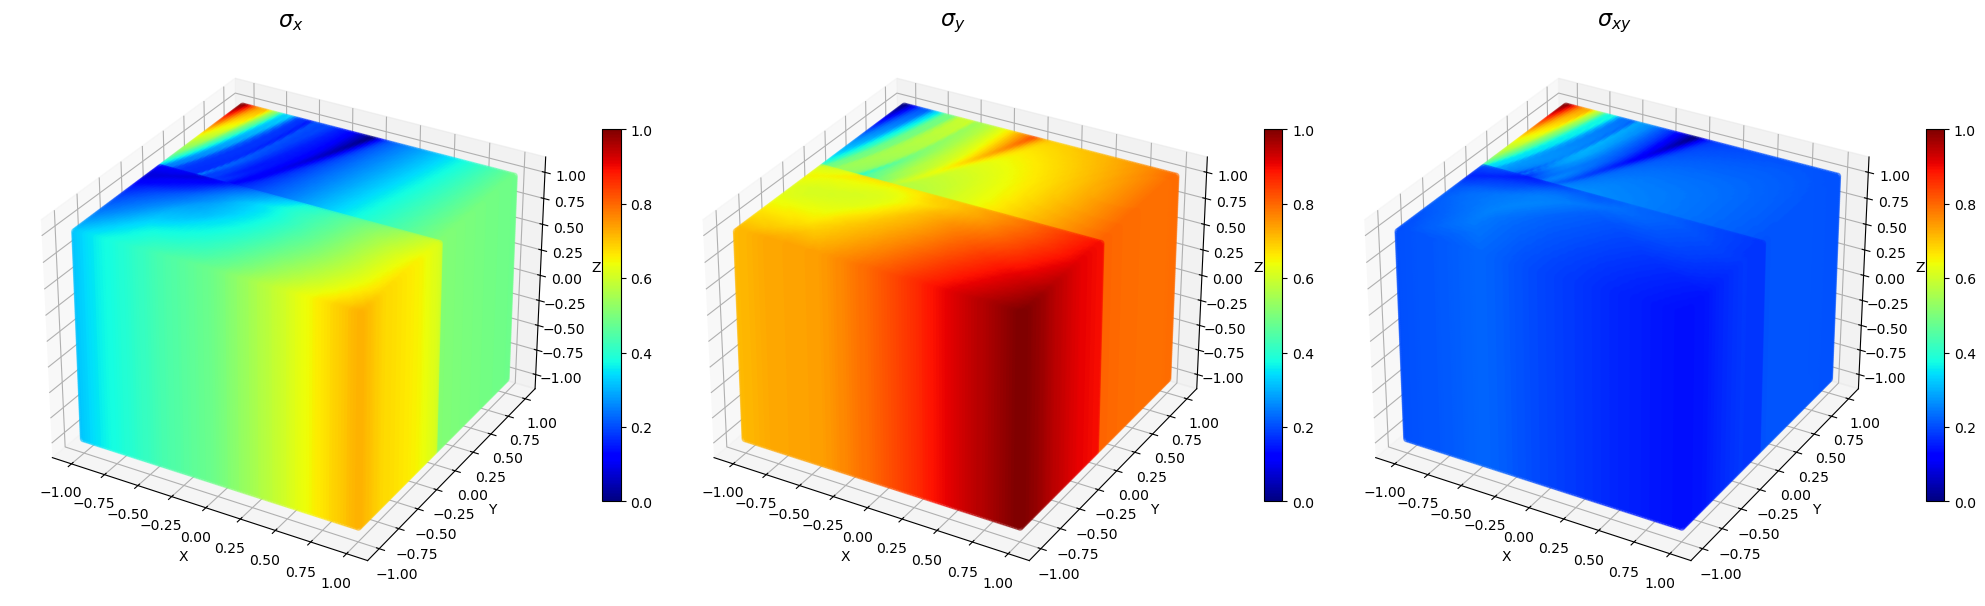

In [23]:
# 创建一个 3×1 的子图布局
fig, axs = plt.subplots(1, 3, figsize=(20, 6.5), subplot_kw={'projection': '3d'})

# 绘制 Ux_ext 图像
axs[0].scatter(X_grid, Y_grid, Z_grid, c=Sxx.ravel(), cmap='jet', alpha=0.5)
axs[0].set_title(r'$\sigma_{x}$', fontsize = 16)
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_zlabel('Z')
fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=axs[0], fraction=0.046, shrink=0.6, aspect=20)

# 绘制 Uy_ext 图像
axs[1].scatter(X_grid, Y_grid, Z_grid, c=Syy.ravel(), cmap='jet', alpha=0.5)
axs[1].set_title(r'$\sigma_{y}$', fontsize = 16)
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
axs[1].set_zlabel('Z')
fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=axs[1], fraction=0.046, shrink=0.6, aspect=20)

# 绘制 Uz_ext 图像
axs[2].scatter(X_grid, Y_grid, Z_grid, c=Sxy.ravel(), cmap='jet', alpha=0.5)
axs[2].set_title(r'$\sigma_{xy}$', fontsize = 16)
axs[2].set_xlabel('X')
axs[2].set_ylabel('Y')
axs[2].set_zlabel('Z')
fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=axs[2], fraction=0.046, shrink=0.6, aspect=20)

# 调整子图间距
plt.tight_layout()

# 显示图像
plt.show()

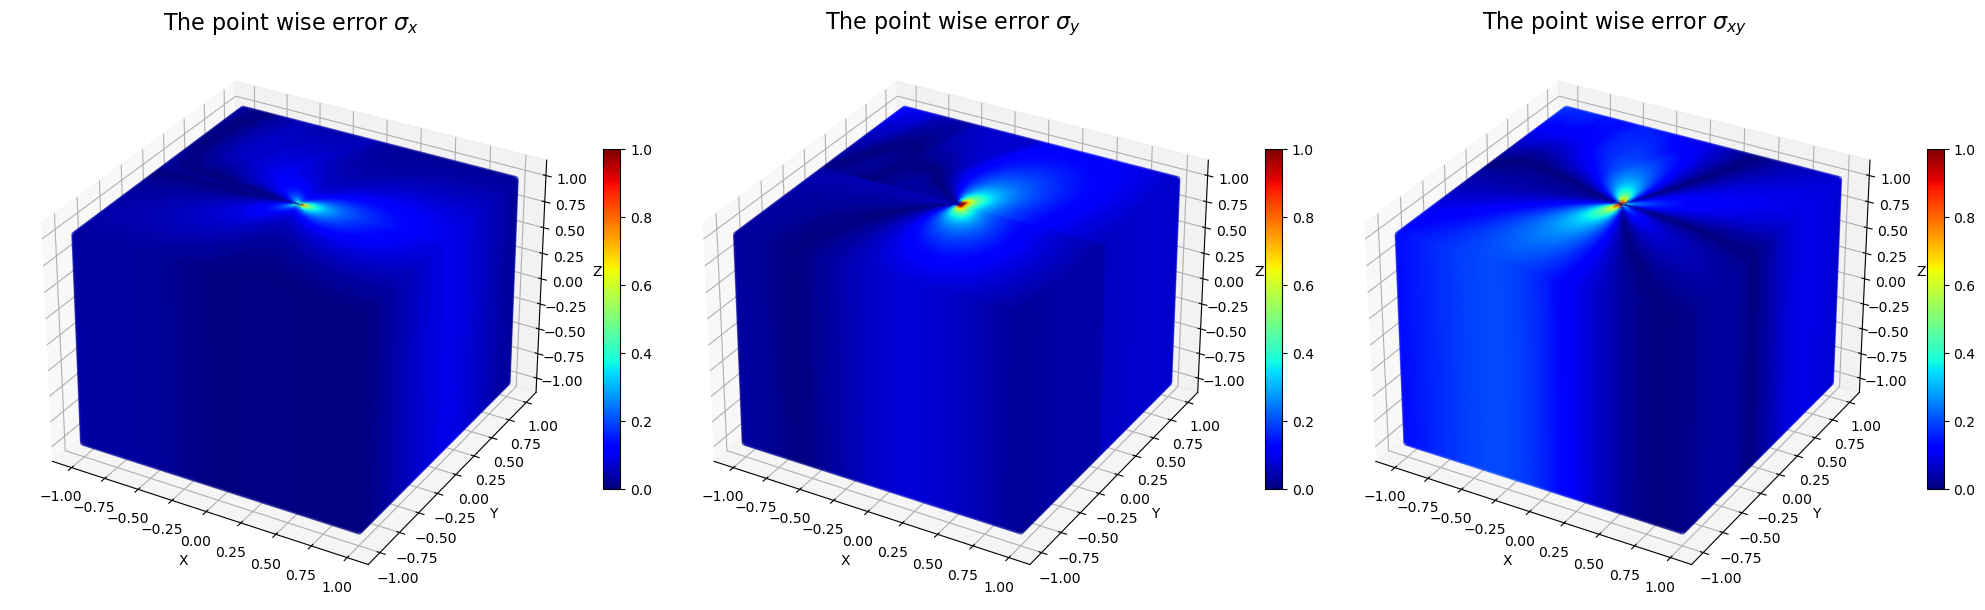

In [24]:
# 创建一个 3×1 的子图布局
fig, axs = plt.subplots(1, 3, figsize=(20, 6), subplot_kw={'projection': '3d'})

e_Sxx = abs(Sxx_ext-Sxx)
e_Syy = abs(Syy_ext-Syy)
e_Sxy = abs(Sxy_ext-Sxy)

# 绘制 Ux_ext 图像
axs[0].scatter(X_grid, Y_grid, Z_grid, c=e_Sxx.ravel(), cmap='jet', alpha=0.5)
axs[0].set_title(r'The point wise error $\sigma_{x}$', fontsize = 16)
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_zlabel('Z')
fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=axs[0], fraction=0.046, shrink=0.6, aspect=20)

# 绘制 Uy_ext 图像
axs[1].scatter(X_grid, Y_grid, Z_grid, c=e_Syy.ravel(), cmap='jet', alpha=0.5)
axs[1].set_title(r'The point wise error $\sigma_{y}$', fontsize = 16)
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
axs[1].set_zlabel('Z')
fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=axs[1], fraction=0.046, shrink=0.6, aspect=20)

# 绘制 Uz_ext 图像
axs[2].scatter(X_grid, Y_grid, Z_grid, c=e_Sxy.ravel(), cmap='jet', alpha=0.5)
axs[2].set_title(r'The point wise error $\sigma_{xy}$', fontsize = 16)
axs[2].set_xlabel('X')
axs[2].set_ylabel('Y')
axs[2].set_zlabel('Z')
fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=axs[2], fraction=0.046, shrink=0.6, aspect=20)

# 调整子图间距
plt.tight_layout()

# 显示图像
plt.show()

In [25]:
# 将三维数组转换为一维数组
Ux_flat = Ux.ravel()
Uy_flat = Uy.ravel()
#Uz_flat = Uz.ravel()
Uhat_flat = Uhat.ravel()

Ux_ext_flat = Ux_ext.ravel()
Uy_ext_flat = Uy_ext.ravel()
#Uz_ext_flat = Uz_ext.ravel()
Uhat_ext_flat = Uhat_ext.ravel()


# 计算误差
errorux_1 = np.linalg.norm(Ux_flat - Ux_ext_flat, 2) / np.linalg.norm(Ux_ext_flat, 2) 
erroruy_1 = np.linalg.norm(Uy_flat - Uy_ext_flat, 2) / np.linalg.norm(Uy_ext_flat, 2) 
#erroruz_1 = np.linalg.norm(Uz_flat - Uz_ext_flat, 2) / np.linalg.norm(Uz_ext_flat, 2)
erroruhat_1 = np.linalg.norm(Uhat_flat - Uhat_ext_flat, 2) / np.linalg.norm(Uhat_ext_flat, 2) 

print('Error Ux: %e' % (errorux_1))
print('Error Uy: %e' % (erroruy_1))
#print('Error Uz: %e' % (erroruz_1))
print('Error Uhat: %e' % (erroruhat_1))

Error Ux: 6.954877e-01
Error Uy: 1.051120e+00
Error Uhat: 4.210245e-01


In [26]:
if np.any(np.isinf(Sxx)) or np.any(np.isnan(Sxx)):
    Sxx = np.nan_to_num(Sxx, nan=0.0, posinf=0.0, neginf=0.0)
if np.any(np.isinf(Sxx_ext)) or np.any(np.isnan(Sxx_ext)):
    Sxx_ext = np.nan_to_num(Sxx_ext, nan=0.0, posinf=0.0, neginf=0.0)
if np.any(np.isinf(Syy)) or np.any(np.isnan(Syy)):
    Syy = np.nan_to_num(Syy, nan=0.0, posinf=0.0, neginf=0.0)
if np.any(np.isinf(Syy_ext)) or np.any(np.isnan(Syy_ext)):
    Syy_ext = np.nan_to_num(Syy_ext, nan=0.0, posinf=0.0, neginf=0.0)
if np.any(np.isinf(Sxy)) or np.any(np.isnan(Sxy)):
    Sxy = np.nan_to_num(Sxy, nan=0.0, posinf=0.0, neginf=0.0)
if np.any(np.isinf(Sxy_ext)) or np.any(np.isnan(Sxy_ext)):
    Sxy_ext = np.nan_to_num(Sxy_ext, nan=0.0, posinf=0.0, neginf=0.0)
# 将三维数组转换为一维数组
Sxx_flat = Sxx.ravel()
Syy_flat = Syy.ravel()
Sxy_flat = Sxy.ravel()
Sxx_ext_flat = Sxx_ext.ravel()
Syy_ext_flat = Syy_ext.ravel()
Sxy_ext_flat = Sxy_ext.ravel()

errorSxx_1 = np.linalg.norm(Sxx_flat-Sxx_ext_flat, 2) / np.linalg.norm(Sxx_ext_flat,2)
errorSyy_1 = np.linalg.norm(Syy_flat-Syy_ext_flat, 2) / np.linalg.norm(Syy_ext_flat,2)
errorSxy_1 = np.linalg.norm(Sxy_flat-Sxy_ext_flat, 2) / np.linalg.norm(Sxy_ext_flat,2)

print('Error2 Sxx: %e' % (errorSxx_1))
print('Error2 Syy: %e' % (errorSyy_1))
print('Error2 Sxy: %e' % (errorSxy_1))

Error2 Sxx: 7.154384e-01
Error2 Syy: 7.117507e-01
Error2 Sxy: 1.032832e+00
